# Using Bayesian optimisation for SOAP power spectrum

The task of this notebook is to demonstrate the performance of Bayesian optimization for SOAP Power Spectrum.  In this notebook we will solve the same problem as in the first example - build an interatomic potential for Zundel cations. To get the best result, we use the optimization process of 3 hyperparameters of the SOAP framework.

When using SOAP, it is important to remember that a large number of parameters must be set in advance, before training. These are the thickness of the Gaussian blur, the number of radial and spherical features, the cutoff radius, and others. Such parameters that are not optimized during training and must be set before it starts are called *hyperparameters* [1]. Accordingly, there is a task to determine these parameters in such a way that the model gives the lowest error. 



## Theoretical prerequisites

Using simple search methods such as Grid Search, or Random Search, is not acceptable in such a case. Firstly, in order to check at least 5 possible points for each hyperparameter with the help of the Grid Search, we need to check 125 combinations, which is too many. Secondly, none of the methods guarantees that the result we get is at least somehow related to the real minimum. It is exactly the search for the optimal value, either by means of predetermined check points or by means of chance. Bayesian optimization presents an opportunity specifically for hyperparameter optimization, that is, it is a systematic method for determining the optimal set of hyperparameters. 

In general, Bayesian optimization belongs to the class of Sequential Model-based Global Optimization (SMBO) algorithms [2], the essence of which consists in the following. SMBO operates on a surrogate function, which is cheaper to work with than with function, that we should optimize (or it works well for the black-box functions, such as in our case). At each step, it optimizes this cheap function, gradually finding its maximum. Such a cheap function could be Expected Improvement (EI):

$$
\mathrm{EI}_{y^{*}}(x):=\int_{-\infty}^{\infty} \max \left(y^{*}-y, 0\right) p_{M}(y \mid x) d y
$$

This formula can be decomposed into two components. At each subsequent step, we search either for the point where there is a high probability of a minimum, or for the point where the variation of the parameter is large enough (because of the $\max$ function, a large variation will lead exactly to a high estimate of the mean value). As a result, the algorithm will gradually learn more and more about the landscape of the function, finding the optimal value of the variable in passing. Such a surrogate function is also called an acquisition function because it defines the next point we would be interested in considering. 

But the next question arises, related to the fact that we know absolutely nothing about the function we are optimizing - how to estimate the values of a function at a point if we do not know what kind of function it is? This requires making prior over the function. The Gaussian process prior is most often used and is worth a closer look. 

A Gaussian process is essentially a generalization of the normal distribution on functions [3]. That is, a process will be called Gaussian if the functions in that process have a Gaussian distribution.  As we know, the normal distribution has two parameters - a vector of mean values (in case of functions it will be the mean function, respectively) and the covariance matrix (in case of functions it will be the covariance function). Accordingly, if we can gradually obtain information about these parameters, we will have more and more precise data about the function we are optimizing. Essentially, the Gaussian process is very similar to Kernel methods. We also compare a new unknown point with familiar samples, and try to predict the result depending on their similarity. Accordingly, it remains to be understood how to obtain the mean and covariance functions from known samples. 

Let $\mathbf{f}$ be the function values we know, $\mathbf{f}_{*}$ be the set of unknown values (which we are interested in evaluating), $\mu, \mu_{*}$ be the mean for known and unknown values respectively, $\Sigma, \Sigma_{*}, \Sigma_{**}$ be the covariance matrix for known data, known-unknown and unknown data [4]. Then we can write that 

$$
\mathbf{f}_{*} \mid \mathbf{f} \sim \mathcal{N}\left(\mu_{*}+\Sigma_{*}^{\top} \Sigma^{-1}(\mathbf{f}-\boldsymbol{\mu}), \Sigma_{* *}-\Sigma_{*}^{\top} \Sigma^{-1} \Sigma_{*}\right)
$$

(this is simply the formula for conditioning a joint Gaussian distribution). This corresponds to a Gaussian process with mean and covariance:

$$
m(x) = m(x)+\Sigma(X, x)^{\top} \Sigma^{-1}(\mathbf{f}-\mathbf{m})
$$
$$
k_{GP}\left(x, x^{\prime}\right) = k\left(x, x^{\prime}\right)-\Sigma(X, x)^{\top} \Sigma^{-1} \Sigma\left(X, x^{\prime}\right)
$$

As you can see, the more points we have, the smaller covariance is, that is pretty reasonable

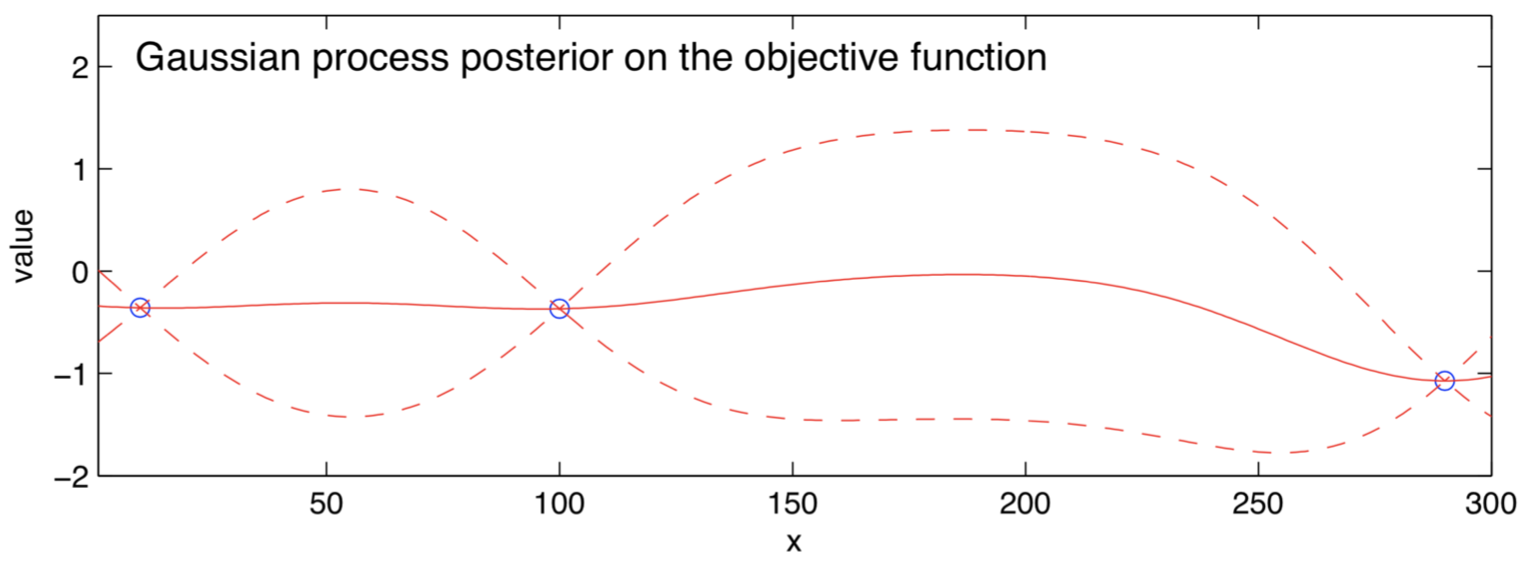

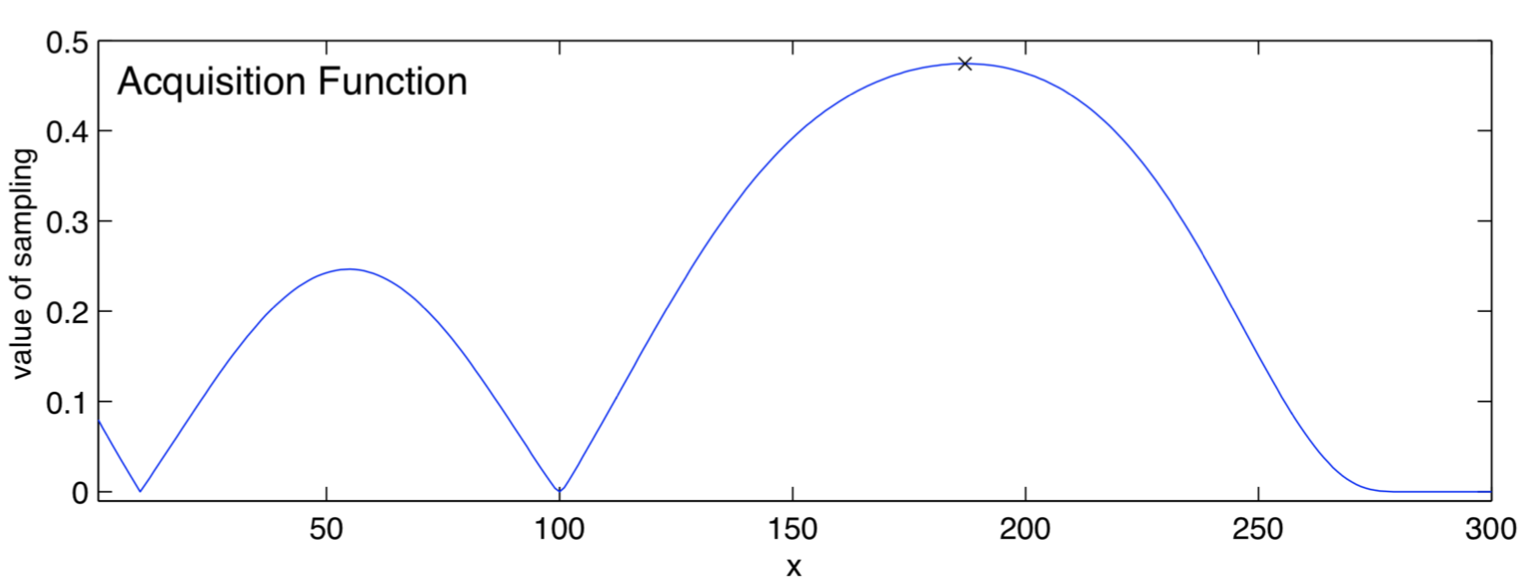

Now let's spin all our considerations in the opposite direction in the form of an algorithm. We set some initial value of the covariance matrix (usually it is an RBF kernel), and calculate the function value at an arbitrary point from the specified range. From this, we can calculate the updated values of the mean and covariance. These values can then be substituted into the Expected Improvement function. It is already quite easy to optimize this function as we know its form and can use algorithms involving the first and second derivatives [5], [6]. Of course, this algorithm requires us to incur additional costs, we have to recalculate the mean and covariance, and optimize the surrogate function. But here we can recall that we specifically took a function whose optimization is a cheap procedure. Therefore, these intermediate calculations will not significantly increase the optimization time. Meanwhile, this algorithm will significantly reduce the number of calculations of the loss function, which is already much more expensive. As a result, we have obtained a way to systematically optimize hyperparameters.  

[1]: Claesen M., De Moor B. Hyperparameter search in machine learning, arXiv preprint arXiv:1502.02127, 2015.

[2]: Hutter F., Hoos H. H., Leyton-Brown K. Sequential model-based optimization for general algorithm configuration, International conference on learning and intelligent optimization, Springer, Berlin, Heidelberg, 507-523, 2011.

[3]: Williams C. K. I., Rasmussen C. E. Gaussian processes for machine learning,  Cambridge, MA : MIT press, V. 2,  No 3, 4, 2006.

[4]: Rasmussen C. E. Gaussian processes in machine learning, Summer school on machine learning,  Springer, Berlin, Heidelberg, 63-71, 2003.

[5]: Frazier P. I. A tutorial on Bayesian optimization, arXiv preprint arXiv:1807.02811, 2018.

[6]: Liu D. C., Nocedal J. On the limited memory BFGS method for large scale optimization, Mathematical programming, V. 45, No 1, 503-528, 1989

Let's move on to the practical use of Bayesian optimization. For this we will use the library *scikit-optimize*, (https://scikit-optimize.github.io/stable/index.html). It can be easily installed via ```pip```:

```bash
$ pip install scikit-optimize
```

This library itself has many options for optimization (including various acquisition functions), methods for analyzing results (including using graphs) and a lot of examples of using the library in practice. We will focus on a few of the simplest commands, which will get you started with the library. 

The main part of the code repeats the first example, we will not dwell on it in too much detail, only pointing out the main blocks and what is directly relevant to the optimization task. First, import the required libraries:

In [1]:
import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score

from skopt import Optimizer #<--- the key element, the object that conducts the optimization
from skopt.space import Real #<--- A class that allows us to define the space in which we will search for our 
                             #     optimal set of hyperparameters
from skopt.plots import plot_convergence #<--- Allows easy graphing of algorithm convergence

And download our dataset

In [2]:
cd i-PI/zundel/

/home/kliavine/molecular-clouds-models/i-PI/zundel


In [3]:
# Load the first N structures of the zundel dataset
N_dataset = 1000
frames = read('zundel_dataset.xyz', index=':{}'.format(N_dataset))
energies = np.loadtxt('zundel_energies.txt')[:N_dataset] 

#Keys of the arrays dictionary
print(frames[0].arrays.keys())

dict_keys(['numbers', 'positions', 'forces'])


Build the GAP model:

In [4]:
def extract_forces(frames,array_key='zeros'):
    f = []
    for frame in frames:
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    try:
        f = np.concatenate(f)
    except:
        pass
    return f

In [5]:
# Number of structures to train the model with
n = 800

global_species = set()
for frame in frames:
    global_species.update(frame.get_atomic_numbers())
global_species = np.array(list(global_species))

np.random.seed(10)
# Split our data in the train and test blocks
def train_test():
    ids = list(range(N_dataset))
    np.random.shuffle(ids)

    train_ids = [int(i) for i in ids[:n]]
    frames_train = [frames[ii] for ii in train_ids]
    y_train = [energies[ii] for ii in ids[:n]]
    y_train = np.array(y_train)
    f_train = extract_forces(frames_train, 'forces')

    test_ids = [int(i) for i in ids[n:]] 
    frames_test = [frames[ii] for ii in test_ids]
    y_train = [energies[ii] for ii in train_ids]
    y_train = np.array(y_train)
    y_test = [energies[ii] for ii in test_ids]
    y_test = np.array(y_test)
    f_test = extract_forces(frames_test, 'forces')
    return frames_train, y_train, f_train, frames_test, y_test, f_test

Create a function to generate a Power Spectrum with defined hyperparameters:

In [6]:
# Atomic energy baseline
atom_energy_baseline = np.mean(energies)/(frames[0].get_global_number_of_atoms())
energy_baseline = {int(species): atom_energy_baseline for species in global_species}
def fixed(number, digits):
    return f"{number:.{digits}f}"

In [7]:
def SOAP_definition(sigma, cutoff, width, compute_gradients):
    # define the parameters of the spherical expansion
    hypers = dict(soap_type="PowerSpectrum",
                  interaction_cutoff=cutoff, 
                  max_radial=6, 
                  max_angular=4, 
                  gaussian_sigma_constant=sigma,
                  gaussian_sigma_type="Constant",
                  cutoff_function_type="RadialScaling",
                  cutoff_smooth_width=width,
                  cutoff_function_parameters=
                        dict(
                                rate=1,
                                scale=3.5,
                                exponent=4
                            ),
                  radial_basis="GTO",
                  normalize=True,
                  optimization=
                        dict(
                                Spline=dict(
                                   accuracy=1.0e-05
                                )
                            ),
                  compute_gradients=compute_gradients
                  )


    soap = SphericalInvariants(**hypers)
    return soap

Let's move on to the most important thing, training and optimization. The key here will be the ```Optimizer``` class.  When you create an instance of a class, you can give it a lot of parameters, the main ones being an array of optimal value areas (in our case, they are
real numbers ```interaction_cutoff```, ```gaussian_sigma_constant``` and ```cutoff_smooth_width```) plus ```n_initial_points```. The latter is responsible for
how many times an instance of the optimizer class will just guess the next hyperparameter value. At ```n=1``` it will randomly choose 1 point, and after that it will already choose the points it thinks are optimal.

In [8]:
# create an instance of the Optimizer class
opt  = Optimizer([Real(0.1, 0.75), Real(2, 6), Real(0, 1)], n_initial_points=1)

outfile = open('losses_information.txt', 'w')
# at each step we will record checked point and optimal one
outfile.write(f'sigma cutoff width loss sigma_opt cutoff_opt width_opt minimal_loss \n')
outfile.close()
for _ in tqdm(range(100), desc="Number of iterations"):
    suggested = opt.ask() # this function allows you to ask the optimizer which set of hyperparameters should be 
                          # requested next
    # break it down into its individual components
    sigma, cutoff, width = suggested
    # define SOAP featurization and train-test splitting
    frames_train, y_train, f_train, frames_test, y_test, f_test = train_test()
    managers = []
    for f in frames_train:
        f.wrap(eps=1e-18)

    soap = SOAP_definition(sigma, cutoff, width, False)
    managers = soap.transform(frames_train)
    # select the sparse points for the sparse kernel method with CUR on the whole training set
    n_sparse = {1:50, 8:100}
    compressor = CURFilter(soap, n_sparse, act_on='sample per species')
    X_sparse = compressor.select_and_filter(managers)

    zeta = 2

    soap = SOAP_definition(sigma, cutoff, width, True)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

    KNM = compute_KNM(tqdm(frames_train, leave=True, desc="Computing kernel matrix"), X_sparse, kernel, soap)

    model = train_gap_model(kernel, frames_train, KNM, X_sparse, y_train, energy_baseline, 
                            grad_train=-f_train, lambdas=[1e-12, 1e-12], jitter=1e-13)

    # make predictions on the test set
    y_pred = []
    f_pred = []

    for f in frames_test:
        positions = f.get_positions()
        f.set_positions(positions+[1,1,1])
        f.wrap(eps=1e-18)
        m = soap.transform(f)
        y_pred.append(model.predict(m))
        f_pred.append(model.predict_forces(m))

    y_pred = np.array(y_pred).flatten()
    f_pred = np.array(f_pred)
    score = get_score(y_pred, y_test)
    RMSE = score['RMSE']
    res = opt.tell(suggested, RMSE) # <--- send the obtained result to the optimizer
    # write down our data to the file
    outfile = open('losses_information.txt', 'a')
    sigma_opt, cutoff_opt, width_opt, result = res.x[0], res.x[1], res.x[2], res.fun 
    outfile.write(f'{fixed(sigma, 2)} {fixed(cutoff,2)} {fixed(width,2)} {fixed(RMSE, 4)} {fixed(sigma_opt, 2)}')
    outfile.write(f' {fixed(cutoff_opt,2)} {fixed(width_opt,2)} {fixed(result, 4)}\n')
    outfile.close()  
    # repeat everything 100 times
print(f'Optimal parameters: gaussian_sigma_constant={fixed(res.x[0], 2)}, interaction_cutoff={fixed(res.x[1], 2)}\n')
print(f'cutoff_smooth_width={fixed(res.x[2], 2)}, RMSE = {fixed(res.fun*1000, 2)} meV')

  0%|          | 0/100 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

/home/kliavine/.local/lib/python3.8/site-packages/skcosmo/utils/_orthogonalizers.py:57: UserWarning: Column vector contains only zeros.
  warnings.warn("Column vector contains only zeros.")


Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

/home/kliavine/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Computing kernel matrix:   0%|          | 0/800 [00:00<?, ?it/s]

Optimal parameters: gaussian_sigma_constant=0.10, interaction_cutoff=3.71

cutoff_smooth_width=0.01, RMSE = 11.17 meV


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

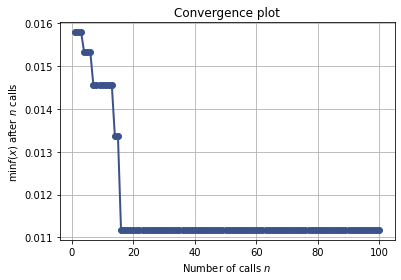

In [9]:
# function for the convergence plotting
plot_convergence(res)

As you can see, this algorithm produces an optimal set of hyperparameters in 20 steps. The remaining iterations are carried out to make sure of the quality of the result obtained. At the same time, thanks to the cheapness of the acquisition function, this algorithm does not become too computationally heavy. 